In [1]:
%matplotlib inline

# Open Supernova Catalog

All data we currently use are come from Open Supernova Catalog – http://sne.space. This catalog contains data for each supernova (SN) in the [JSON](https://en.wikipedia.org/wiki/JSON) file, all availible fields can be found in [schema description](https://github.com/astrocatalogs/supernovae/blob/5d080fc/SCHEMA.md).

You can select SNe at http://sne.space and remember their names or press 'export CSV' button to obtain a table with the main information about selected SNe.

# Download data with `SNFiles`

`curves` module contains class `SNFiles` that allows you to download, keep up to date, and get a lost of SN JSON files.

In [15]:
from thesnisright.load.curves import SNFiles

# Large files, wait a little to download:
sn_files = SNFiles(['SN1993A', 'SN1987A'])
# Also you can specify .csv from sne.space instead of list

# Now files are downloaded to ./sne directory
print(sn_files.filepaths)

['/home/balodja/projects/one day/theSNisRight/sne/SN1993A.json', '/home/balodja/projects/one day/theSNisRight/sne/SN1987A.json']


`curves.SNFiles` constructor has two useful keyword arguments: `offline` and `update`. If you set `offline=True`, no connection to OSC will be opened. If you set `update=False` data will be downloaded only if no data is unavaliable locally

# Load data from JSON with `OSCCurve`

You can read `JSON` data file using `curves.OSCCurve`. This class has two useful class methods: `.from_name` (obtain file using `curves.SNFiles`, can download data) and `from_json` (load data from JSON file).

In [3]:
import os
from thesnisright import OSCCurve

name = 'SN1993A'
sn_from_name = OSCCurve.from_name(name)
sn_from_json = OSCCurve.from_json(os.path.join('./sne', name + '.json'))
assert sn_from_name.json == sn_from_json.json

`curves.OSCCurve` has a lot of attributes that describe properties of SN data: `.name`, `.has_spectra`, `.redshift`, `.host` and so on.

In [4]:
from thesnisright.load.curves import OSCCurve

sn = OSCCurve.from_name('SN1993A')
print('''
SN: {}
Spectra in data {}
Redshift estimations: {}
What galaxy is SN host: {}
'''.format(sn.name, sn.has_spectra, ', '.join(map(str, sn.redshift)), ' or '.join(sn.host)))


SN: SN1993A
Spectra in data True
Redshift estimations: 0.0293, 0.02978
What galaxy is SN host: 2MASX J07391822-6203095 or A073918-6203 or 2MASXJ07391822-6203095



# Data structure

For the purposes of multistate Gaussian process approximation `curves.OSCCurve` has two representaions of the data: as an ordered dictionary with the data in every band and as flat arrays. The first representation is more convinient to use by human.

### Dictionary representaion

Availible bands for SN1993A: B, I, V


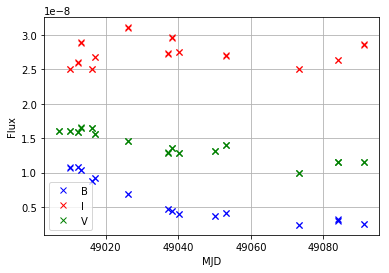

In [5]:
import matplotlib.pyplot as plt
from thesnisright.load.curves import OSCCurve

colors = {'B': 'blue', 'I': 'red', 'V': 'green'}

sn = OSCCurve.from_name('SN1993A')
print('Availible bands for {}: {}'.format(sn.name, ', '.join(sn.bands)))

plt.xlabel('MJD')  # Modified Julian data, days
plt.ylabel('Flux')
for band, light_curve in sn.items():
    plt.plot(light_curve.x, light_curve.y, 'x', color=colors[band], label=band)
plt.legend()
plt.grid()

Required bands can be specified in consructor

In [6]:
from thesnisright.load.curves import OSCCurve, EmptyPhotometryError

sn = OSCCurve.from_name('SN1993A', bands='B,I')
assert 'B' in sn
assert 'I' in sn
assert 'V' not in sn

sn = OSCCurve.from_name('SN1993A', bands='B')
assert 'B' in sn
assert 'V' not in sn
assert 'I' not in sn

sn = OSCCurve.from_name('SN1993A', bands=['B', 'I'])
assert 'B' in sn
assert 'I' in sn
assert 'V' not in sn

try:
    sn = OSCCurve.from_name('SN1993A', bands='X')
except EmptyPhotometryError as e:
    print(e)

SN1993A data file has not any photometrical observations for bands ('X',)


### Photometry data

As you have seen above, every light curve is a `numpy.recarray` with fields `x` and `y` that specifies time and flux respectively. There are three more fieids: `x_err`, `err` and `isupperlimit`. `x_err` specifies time error, usually it is small enough for us. `err` is an error in `y` (flux) measerment. `isupperimit` specifies if current observation shows no signal from the object and sets upper limit to its flux.

So we have three sorts of photometry observations in the data:
* Normal observation with error: `.err` is positive finite and `.isupperlimit` is `False`
* Observation without specified error: `.err` is infinite (`np.nan` for now) and `.isupperlimit` is `False`
* Upper limit observation: `.isupperlimit` is `True`, `y` specifies maximum possible flux.

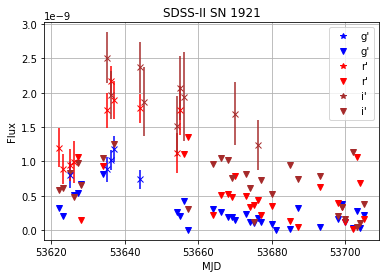

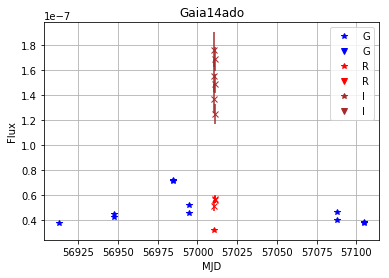

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from thesnisright.load.curves import OSCCurve

def plot_lc(name, colors):
    sn = OSCCurve.from_name(name, bands=colors.keys())
    plt.figure()
    plt.xlabel('MJD')  # Modified Julian data, days
    plt.ylabel('Flux')
    plt.title(name)
    for band, light_curve in sn.items():
        normal = light_curve[(np.isfinite(light_curve.err)) & (~light_curve.isupperlimit)]
        wo_errors = light_curve[(~np.isfinite(light_curve.err)) & (~light_curve.isupperlimit)]
        upper_limit = light_curve[light_curve.isupperlimit]
        plt.errorbar(normal.x, normal.y, normal.err, marker='x', ls='', color=colors[band])
        plt.plot(wo_errors.x, wo_errors.y, '*', color=colors[band], label=band)
        plt.plot(upper_limit.x, upper_limit.y, 'v', color=colors[band], label=band)
    plt.legend()
    plt.grid()

plot_lc('SDSS-II SN 1921', {"g'": 'blue', "r'": 'red', "i'": 'brown'})
plot_lc('Gaia14ado', {'G': 'blue', 'R': 'red', 'I': 'brown'})

### Arrays representaion

Arrays representaion is not useful in data plotting, but can be useful in data processing.  Short description of this representation:
* `.X` – 2-D array, first column is index, that corresponds to the band (by the index in `list(OSCCurve.keys())`), the second column is stacked `.x` from dictionary representation
* `.y` – 1-D array, all `.y` from dictionary representation, they are normalized by the facor `.norm` and stacked in the same order as for `.X`
* `.err` – 1-D array, errors corresponding to `.y`, normalized by factor `.norm`
* `.norm` — float, normalization factor for `.y` and `.err`. Original fluxes and errors (as in dictionaries) are their array representations multiplied by `.norm`

# Data preporation

`curves.OSCCurve` has several methods to bin, filter and transforma data

### Binning

It can be useful to bin data before usage, because we are not interested in fast flux fluctuations. `curves.OSCCurve.binned(bin_width, discrete_time)` returns the `OSCCurve` object, where several observations are sampled to one observation if they were made during `bin_width` days interval. Now only `discrete_time=True` is tested, in this case `OSCCurve[band].x % bin_width == 0.5 * bin_width`.

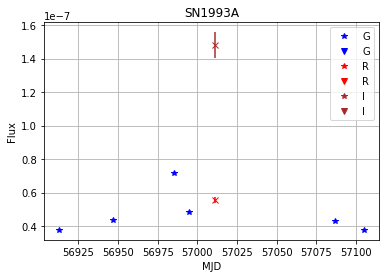

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from thesnisright.load.curves import OSCCurve

colors = {'G': 'blue', 'R': 'red', 'I': 'brown'}

bin_width = 2

sn = OSCCurve.from_name('Gaia14ado', bands=colors.keys())
sn = sn.binned(bin_width=2, discrete_time=True)
np.testing.assert_allclose(sn.arrays.x[:,1] % bin_width, 0.5 * bin_width)

plt.figure()
plt.xlabel('MJD')  # Modified Julian data, days
plt.ylabel('Flux')
plt.title(name)
for band, light_curve in sn.items():
    normal = light_curve[(np.isfinite(light_curve.err)) & (~light_curve.isupperlimit)]
    wo_errors = light_curve[(~np.isfinite(light_curve.err)) & (~light_curve.isupperlimit)]
    upper_limit = light_curve[light_curve.isupperlimit]
    plt.errorbar(normal.x, normal.y, normal.err, marker='x', ls='', color=colors[band])
    plt.plot(wo_errors.x, wo_errors.y, '*', color=colors[band], label=band)
    plt.plot(upper_limit.x, upper_limit.y, 'v', color=colors[band], label=band)
plt.legend()
plt.grid()

### Filtering

`curves.OSCCurve` can be cleaned out of upper limits or data without errors using `.filtered(with_upper_limits=False, with_inf_e_flux=False, sort='default')` method. Also, output `curves.OSCCurve.keys()` can be sorted by the number of photometry observations.

In [10]:
import numpy as np
from thesnisright.load.curves import OSCCurve

def number_of_upper_limits(sn):
    return sum(np.sum(lc.isupperlimit) for lc in sn.values())

def number_of_wo_errors(sn):
    return sum(np.sum(~np.isfinite(lc.err)) for lc in sn.values())

sn = OSCCurve.from_name('SDSS-II SN 1921', bands="g',r',i'")
assert number_of_upper_limits(sn) > 0
sn = sn.filtered(with_upper_limits=False, with_inf_e_flux=True)
assert number_of_upper_limits(sn) == 0

sn = OSCCurve.from_name('Gaia14ado', bands='G,R,I')
assert number_of_wo_errors(sn) > 0
sn = sn.filtered(with_upper_limits=True, with_inf_e_flux=False)
assert number_of_wo_errors(sn) == 0

### Set errors to observations without errors

In [11]:
import numpy as np
from thesnisright.load.curves import OSCCurve

def number_of_wo_errors(sn):
    return sum(np.sum(~np.isfinite(lc.err)) for lc in sn.values())

sn = OSCCurve.from_name('Gaia14ado', bands='G,R,I')
assert number_of_wo_errors(sn) > 0
sn = sn.set_error(rel=0.01)  # Set 1% error to all data without errors
assert number_of_wo_errors(sn) == 0

### Transform upper limit to normal observation

It can be useful to convert upper limit observations to "normal" observations with large errors, method `OSCCurve.transform_upper_limit_to_normal()` will help you with this. Some of upper limit observations have very bad quality, so you can specify in which time interval upper limits should be transformed and then remove all other upper limits. By default only upper limits that were obtained before and after normal observations are used in this transformation. Currently, `.transform_upper_limit_to_normal()` sets `.y` to the half of initial `.y` and `.err` to the initial `.y`.

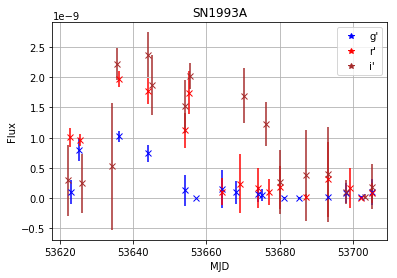

In [12]:
import matplotlib.pyplot as plt
from thesnisright.load.curves import OSCCurve

colors = {"g'": 'blue', "r'": 'red', "i'": 'brown'}

sn = OSCCurve.from_name('SDSS-II SN 1921', bands=colors.keys())
sn = sn.binned(bin_width=5)
sn = sn.transform_upper_limit_to_normal()
sn = sn.filtered(with_upper_limits=False, with_inf_e_flux=True)

plt.figure()
plt.xlabel('MJD')  # Modified Julian data, days
plt.ylabel('Flux')
plt.title(name)
for band, light_curve in sn.items():
    normal = light_curve[(np.isfinite(light_curve.err)) & (~light_curve.isupperlimit)]
    wo_errors = light_curve[(~np.isfinite(light_curve.err)) & (~light_curve.isupperlimit)]
    upper_limit = light_curve[light_curve.isupperlimit]
    plt.errorbar(normal.x, normal.y, normal.err, marker='x', ls='', color=colors[band])
    plt.plot(wo_errors.x, wo_errors.y, '*', color=colors[band], label=band)
plt.legend()
plt.grid()